In [2]:
#Imports
import csv
import os
import glob
import json
import re
import string
import pandas as pd
import numpy as np
import scipy
from scipy import constants
import seaborn as sns
import matplotlib.pyplot as plt

#SciKit
from sklearn.datasets import load_iris
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

from sklearn.naive_bayes import GaussianNB

#NLTK
import nltk
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

#Gensim
import gensim 
from gensim.models import Word2Vec, KeyedVectors


DATA PREPARATION

Before the content of the tweets can be analyzed, we need to acquire them and convert them into a form that can be fed into our feature engineering program. Thus, we will need to tokenize the Tweets. 

1. First, we will need to iterate through all of the .csv files of Tweets containing illicit material. 

2. The contents of these .csv files need to fed into the nltk TweetTokenizer() to be tokenized.

3. Tokenized Tweets will then appended to a new .json file. Assuming that Rudniy conducts his Tweet scraping in the same manner as the 'jailbait' Tweets, we will create a different json file for each "keyword".

4. In tandem, I need to create a parallel file of labels for all Tweets. I think it will be ok if this is simply a .json file. This is necessary in order to use sklearn's ML models. 

In [26]:
#This code gets the number of folders in a folder. This will be more important once we have more data. - FIX

path = "./Tweet_Datasets"

def count_folders(path):
  count = 0
  for folder in os.listdir(path):
    if os.path.isfile(os.path.join(path, folder)):
      count += 1
  return count

number_of_folders = count_folders(path)
print(number_of_folders)

0


In [4]:
#This code iterates through the #jailbait .csv files and appends all file names to a list 'file_names'

path = "./Tweet_Datasets/collections - #jailbait/*.csv"
file_names = []
for fname in glob.glob(path):
    file_names.append(fname)

In [5]:
#This code iterates through each file in 'file_names' and appends all Tweets to a single noise_amp list.

def returnFileNames(index):
    return file_names[index]

currentFile = 0
tweetText = []
tweetTime = []

while (currentFile < len(file_names)):
    file_path = returnFileNames(currentFile)

    if os.path.exists(file_path):
        with open(file_path, 'r') as rf:
            csv_reader = csv.reader(rf, delimiter=',')
            for row in csv_reader:
                if len(row) >= 2:
                    tweetText.append(row[1])
                    tweetTime.append(row[0])
    else:
        print(f"File not found: {file_path}")
    currentFile = currentFile + 1

print(tweetText)
print(tweetTime)


['text', 'RT @SelenasWankBank: And for the jailbait fans, Selena at 17. #SelenaGomez #bikini #teen #jailbait #tits #boobs #breasts https://t.co/Qo3MJ…', "I'm 17... I'm jailbait", 'Florida breeds jailbait.', 'Jurina is really jailbait', 'Jacob Davies out on jailbait patrol', 'Jacob Davies out on jailbait patrol', 'I love when Jailbait teaches me new abbreviations. ☺️', '@heartofhannah1 oh you and your jailbait better not start tonight !', 'Always a nice surprise to bump into @lukecotty of a morning. #JailBait', 'DAMN THOSE ARMS, HERCULES! \nHow old is this actor? Is it jailbait?\n\n#OnceUponATime', 'RT @TROLLGAWDD: JAILBAIT. \nWHATS THAT SPELL? \nCHILD PREDATOR CHARGES', 'cell-fie\nbecause jailbait\nlmfao https://t.co/meQXdPoA4b', 'RT @txdaddy70: Retweet if you like #jailbait https://t.co/XICxJ39Lhh', 'Dam. 14 tho \n#jailbait #wouldbeworthit https://t.co/oUPZrMdzaE', 'RT @MDelhome: #jailbait part 1 https://t.co/o4OxzhjDp9', 'WISHBONE ASH - Jailbait https://t.co/MQxl3IGJmz #nowplaying #l

In [10]:
#This code implements a function that removes stopwords and punctuation and appends each tokenized Tweet to a list 'tokenized_tweets' 
#I still need to decide how to clean punctuation from Tweets without cleaning hashtags.

def cleanText(tweet):
    # removing the urls from the text
    tweet = re.sub(r'((www.\S+)|(https?://\S+))', r"", tweet)
    
    #removing the numbers from the text
    tweet = re.sub(r'[0-9]\S+', r'', tweet)
    
    #Removes tags from tweets except for hashtags
    tweet = re.sub(r'(@\S+)', r'', tweet)
    
    # removing the punctuation from the text
    tweet_without_punctuation = [char for char in tweet if char not   
                                in string.punctuation]
    
    # converting the list to string 
    tweet_without_punctuation = "".join(tweet_without_punctuation) 
    
    # set of stop words 
    stop_words = set(stopwords.words("english"))
    
    # removing the stop words 
    tweet_without_stopwords = [word for word in  
                              tweet_without_punctuation.split()
                              if word.lower() not in stop_words]
    return tweet_without_stopwords


In [11]:
nltk.download('stopwords')

tokenized_tweets = []

for i in range(0, len(tweetText)):
    tweet_tokens = cleanText(tweetText[i])
    tokenized_tweets.append(tweet_tokens)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/joeyholzman/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [12]:
print(tokenized_tweets)

[['text'], ['RT', 'jailbait', 'fans', 'Selena', 'SelenaGomez', 'bikini', 'teen', 'jailbait', 'tits', 'boobs', 'breasts'], ['Im', 'Im', 'jailbait'], ['Florida', 'breeds', 'jailbait'], ['Jurina', 'really', 'jailbait'], ['Jacob', 'Davies', 'jailbait', 'patrol'], ['Jacob', 'Davies', 'jailbait', 'patrol'], ['love', 'Jailbait', 'teaches', 'new', 'abbreviations', '☺️'], ['oh', 'jailbait', 'better', 'start', 'tonight'], ['Always', 'nice', 'surprise', 'bump', 'morning', 'JailBait'], ['DAMN', 'ARMS', 'HERCULES', 'old', 'actor', 'jailbait', 'OnceUponATime'], ['RT', 'JAILBAIT', 'WHATS', 'SPELL', 'CHILD', 'PREDATOR', 'CHARGES'], ['cellfie', 'jailbait', 'lmfao'], ['RT', 'Retweet', 'like', 'jailbait'], ['Dam', 'tho', 'jailbait', 'wouldbeworthit'], ['RT', 'jailbait', 'part', '1'], ['WISHBONE', 'ASH', 'Jailbait', 'nowplaying', 'listenlive'], ['RT', 'californiagirl', 'jailbait', 'found'], ['RT', 'like', 'jailbait', 'teen', 'ass'], ['RT', 'Damnteen', 'nude', 'jailbait'], ['sweat', 'jailbait', '♥', '♥'], 

In [41]:
#This code writes all tokenized Tweets in the list 'tokenized_tweets' to a .csv file.

#with open('./Tweet_Datasets/Tokenized_Tweets/Tokenized_Tweets.csv', 'w', newline='') as file:
 #   writer = csv.writer(file)
 #   field = ["text"]
  #  writer.writerow(field)
   # for i in range(0, len(tokenized_tweets)):
    #    writer.writerow(tokenized_tweets[i])

In [13]:
#This code writes all tokenized Tweets and timestamps to a .json file.

with open('./Tweet_Datasets/Tokenized_Tweets/Tokenized_Tweets.json', 'w') as f:
    tweet_data = []
    for i in range(0, len(tokenized_tweets)):
        tweet_entry = {
            "Tweet": tokenized_tweets[i],
            "Timestamp": tweetTime[i]
        }
        tweet_data.append(tweet_entry)

    json.dump(tweet_data, f, indent=6)


In [14]:
#This code returns how many Tweets have been classified

def totalVerified():
    with open('./Tweet_Datasets/Tokenized_Tweets/Tokenized_Tweets.json') as data_file:
        data = json.load(data_file)
        total = 0
        for entry in data:
            if "Classification" in entry:
                total += 1
    return total

print("Total verified: " + str(totalVerified()))

Total verified: 0


In [14]:
#This code appends all classified Tweets to a Classified_Tweets .json file for safety

with open('./Tweet_Datasets/Tokenized_Tweets/Tokenized_Tweets.json') as data_file:
        data = json.load(data_file)
        
classified_tweets = []

for entry in data:
    if "Classification" in entry:
        classified_tweets.append(entry)

with open('./Tweet_Datasets/Classified_Tweets/Classified_Tweets.json', 'w') as f:
    json.dump(classified_tweets, f, indent=6)

/var/folders/97/pcrshgh166n68txwpwsjc2540000gn/T/ipykernel_66919/429439226.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=classifications, palette="dark", edgecolor=".6")


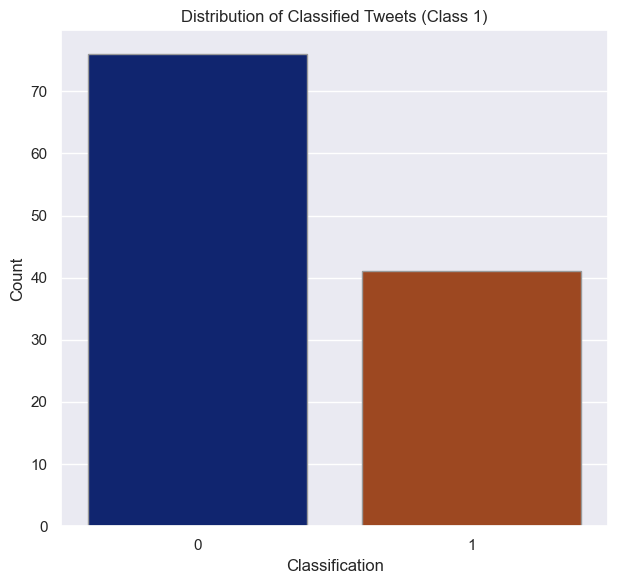

In [18]:
#This code creates a data visualization of currently classified Tweets
#Uses the matplotlib library

with open('./Tweet_Datasets/Classified_Tweets/Classified_Tweets.json') as f:
    classified_tweets = json.load(f)

classifications = [entry["Classification"] for entry in classified_tweets]

sns.set(style="darkgrid")
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 2)
sns.countplot(x=classifications, palette="dark", edgecolor=".6")
plt.title('Distribution of Classified Tweets (Class 1)')
plt.xlabel('Classification')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

FEATURE ENGINEERING

Convert the Tweet text data into numerical features using appropriate text vectorization techniques, such as Bag-of-Words (BoW), Term Frequency-Inverse Document Frequency (TF-IDF), or word embeddings. Both SVM and Naive Bayes classifiers can work with these types of representations. 


Text Vectorization
Bag-of-Words (BoW)
a. Bag-of-Words is a simple text representation technique that converts text data into a matrix of word occurrences. Each row in the matrix represents a tweet, and each column represents a unique word from the entire corpus of tweets.

b. Use scikit-learn library
Term Frequency-Inverse Document Frequency (TF-IDF)
a. TF-IDF is another text representation technique that takes into account the importance of words based on their frequency in a particular tweet and across the entire corpus.

b. Use scikit-learn library
Word Embeddings
a. Word embeddings represent words as dense vector representations in a continuous vector space. We can use pre-trained word embeddings or train our own embeddings 

b. Libraries such as Word2Vec or FastText 



In [19]:
#Extract features using count vectorizer
preprocessor = lambda x: ' '.join(x)
vectorizer = CountVectorizer(dtype = 'uint8', preprocessor = preprocessor, lowercase = False)
df_countvectorizer = vectorizer.fit_transform(tokenized_tweets)
print(df_countvectorizer.shape)

(26518, 17826)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(tweets, labels, test_size=0.2, random_state=42)

In [ ]:
# splitting the features into train and test
X_train, X_test, y_train, y_test = train_test_split(  
                                                df_countvectorizer,  
                                                df["target"],   
                                                test_size=0.2,  
                                                 random_state=0)

# Multinomial Naive Bayes Classifier
classifier = MultinomialNB()
classifier.fit(X_train, y_train)

In [ ]:
# predicting the labels 
pred = classifier.predict(X_test)
print(classification_report(y_test, pred))